# Big Data Project - Xiachufang（下厨房）

In [2]:
import requests
from bs4 import BeautifulSoup
import csv
import json
import jieba
import pandas as pd
from pandas import Series,DataFrame
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)
from plotly.offline import iplot
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout
from plotly.graph_objs import Bar
import plotly.offline as off
from sklearn.manifold import TSNE

# 1. 24-hour pop recipes in Xiachufang

In [ ]:
url_page1='https://www.xiachufang.com/activity/site/?order=pop&page='
urls = []
for i in range(1,51):
    url = url_page1 + str(i)
    urls.append(url)

def get_one_page(url):
    r = requests.get(url)
    mypage = bs4.BeautifulSoup(r.text, 'lxml')
    mycooks = mypage.find_all('div', attrs={'class': 'dish-280'})


    cooks = []
    for mycook in mycooks:
    
        title = mycook.find('p',attrs={'name ellipsis red-font'}).find('a').text
        desc = mycook.find('p',attrs={'desc'}).text
        time = mycook.find('p',attrs={'pure-u-1-2'}).text
        like = mycook.find('span',attrs={'n-diggs'}).text
        comment = mycook.find('span',attrs={'n-comments'}).text
        user = mycook.find('div',attrs={'author clearfix ellipsis'}).find('a').text.strip()
        location = mycook.find('span',attrs={'location gray-font'})
        if location == None:
            location = location 
        else:
            location = location.text.strip()
            
    
        cooks.append([title,desc,time,like,comment,user,location])
    
    return cooks

all_cooks = []
for url in urls:
    all_cooks.extend(get_one_page(url))

df = pandas.DataFrame(all_cooks, columns=['title','desc','time','like',
                                      'comment','user','location'])
#df
#location =df['location'].value_counts().plot(kind='bar')
#location

all_location = []
for x in df['location']:
    if x == None:
        all_location.append(x)
    else:
        all_location.append(x[1:3])
df['location'] = all_location

s = df['location'].value_counts()
d = s.to_frame().reset_index().rename(columns={'index': 'name', 'location': 'value'})
list(d.T.to_dict().values())

Based on location data, we plot user disribution map of China which can be viewed in ppt.

# 2. Monthly pop recipes in Xiachufang

In [ ]:
url_one = 'https://www.xiachufang.com/explore/?page='
urls = []
for i in range(1,40):
    url = url_one + str(i)
    urls.append(url)
    
all_names = []
all_hots = []
all_authors=[]
all_materials=[]


for url in urls:
    pages = BeautifulSoup(requests.get(url).text)

    
    names = []
    for n in pages.find_all('p', attrs={'class':'name'}):
        names.append(n.text.strip())
        
        
    authors = []
    for a in pages.find_all('p', attrs={'class':'author'}):
        authors.append(a.text.strip())
        
    
    hots = []
    for h in pages.find_all('span', attrs={'class': 'bold'}):
        hots.append(h.text)
        
        
    materials=[]
    for m in pages.find_all('p', attrs={'class':'ing ellipsis'}):
        materials.append(m.text.strip())
    
   
    
    all_names.extend(names)
    all_hots.extend(hots)
    all_authors.extend(authors)
    all_materials.extend(materials)
    
    
    for index,item in enumerate(all_hots):
        all_hots [index] = int(item)
#str轉整型
    
with open('monthly pop recipes.csv','w') as f:
    writer = csv.writer(f)
    header = ['names','hots','authors','materials']
    writer.writerow(header)
    writer.writerows(zip(all_names,all_hots,all_authors,all_materials))

In [118]:
df= pd.read_csv("monthly pop recipes.csv")
#df
#七天之內最熱門的菜譜 包括名稱，有多少人做過，發布者，菜譜

In [119]:
rank = df.sort_values(by = ['hots'],ascending=False)
#rank
#按照熱度（七天內多少人做過 排序）

In [120]:
data = [go.Bar(
    
            x=rank['names'],
            y=rank['hots'][:10],
            marker= dict(
            color=['rgba(222,45,38,0.8)','rgba(204,204,204)', 
               'rgba(204,204,204)', 'rgba(204,204,204)',
               'rgba(204,204,204)','rgba(204,204,204)','rgba(222,45,38,0.8)','rgba(204,204,204)', 
               'rgba(204,204,204)', 'rgba(204,204,204)', 'rgba(204,204,204)'])
    )]

iplot({"data":data,
     "layout":Layout(title = "Top 10 in a Week")})

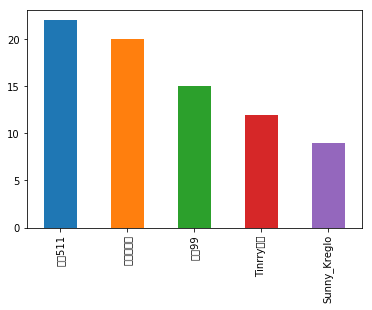

In [121]:
au=df['authors'].value_counts()[:5].plot(kind='bar')
#au.reset_index()
#出現頻率最高的作者
#au
#由于作者名称为中文，后期利用ps标注

In [122]:
all_ma=df['materials'].value_counts().index
#all_ma

In [123]:
all_ma=[]
for material in df['materials']:
    m=list(jieba.cut(material))
    all_ma.extend(m)
#all_ma

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/sk/fp6ry8ss3md7gdyr3b1qcnb80000gn/T/jieba.cache
Loading model cost 1.625 seconds.
Prefix dict has been built succesfully.


In [125]:
ma_count={}
for material in all_ma:
    if material not in ma_count:
        ma_count[material] = 1
    else:
        ma_count[material] = ma_count[material]+1
#ma_count

# 3. Foreign recipes in Xiachufang

In [ ]:
def start_requests(url):
    r = requests.get(url)
    return r.content

def get_page(text):
    soup = BeautifulSoup(text, 'html.parser')
    cooking_yues= soup.find_all('div', attrs={'class':'info pure-u'})
    pages = []
    for cooking_yue in cooking_yues:
        url = cooking_yue.find('a').attrs['href']
        #print(url)
        url2 = 'http://www.xiachufang.com'+url
        pages.append(url2)
    return pages

def parse_page(text):
    soup = BeautifulSoup(text, 'html.parser')
    mydict = {}
    mydict['name'] = soup.find('h1', attrs={'class': 'page-title'}).text.strip()
    mydict['rate'] = soup.find('span', attrs={'class':'number'}).text
    mydict['hot'] = soup.find('div',attrs={'class':'cooked float-left'}).find('span').text
    mydict['time'] = soup.find('span', attrs={'itemprop':'datePublished'}).text
    return mydict

def write_json(result):
    s = json.dumps(result, indent = 4, ensure_ascii=False)
    with open('1_dongnanya_hot.json', 'w', encoding = 'utf-8') as f:
        f.write(s)
        
def main():
    for i in range(1,11):
        url = 'https://www.xiachufang.com/category/51965/?page={}'.format(i)
        text = start_requests(url)
        pageurls = get_page(text) # 解析一级页面
        for pageurl in pageurls: # 解析二级页面 
            page = start_requests(pageurl)
            mydict = parse_page(page)
            result_list.append(mydict)
    write_json(result_list) # 所有菜谱都存进去之后一起输出到文件




if __name__ == '__main__':
    result_list = []
    main()


In [ ]:
def start_requests(url):
    r = requests.get(url)
    return r.content

def get_page(text):
    soup = BeautifulSoup(text, 'html.parser')
    cooking_yues= soup.find_all('div', attrs={'class':'info pure-u'})
    pages = []
    for cooking_yue in cooking_yues:
        url = cooking_yue.find('a').attrs['href']
        #print(url)
        url2 = 'http://www.xiachufang.com'+url
        pages.append(url2)
    return pages

def parse_page(text):
    soup = BeautifulSoup(text, 'html.parser')
    mydict = {}
    mydict['name'] = soup.find('h1', attrs={'class': 'page-title'}).text.strip()
    mydict['rate'] = soup.find('span', attrs={'class':'number'}).text
    mydict['hot'] = soup.find('div',attrs={'class':'cooked float-left'}).find('span').text
    mydict['time'] = soup.find('span', attrs={'itemprop':'datePublished'}).text
    return mydict

def write_json(result):
    s = json.dumps(result, indent = 4, ensure_ascii=False)
    with open('2_korean_hot.json', 'w', encoding = 'utf-8') as f:
        f.write(s)
        
def main():
    for i in range(10):
        url = 'https://www.xiachufang.com/category/40080/?page={}'.format(i)
        text = start_requests(url)
        pageurls = get_page(text) # 解析一级页面
        for pageurl in pageurls: # 解析二级页面 
            page = start_requests(pageurl)
            mydict = parse_page(page)
            result_list.append(mydict)
    write_json(result_list) # 所有菜谱都存进去之后一起输出到文件
    


if __name__ == '__main__':
    result_list = []
    main()

In [ ]:
def start_requests(url):
    r = requests.get(url)
    return r.content

def get_page(text):
    soup = BeautifulSoup(text, 'html.parser')
    cooking_yues= soup.find_all('div', attrs={'class':'info pure-u'})
    pages = []
    for cooking_yue in cooking_yues:
        url = cooking_yue.find('a').attrs['href']
        #print(url)
        url2 = 'http://www.xiachufang.com'+url
        pages.append(url2)
    return pages

def parse_page(text):
    soup = BeautifulSoup(text, 'html.parser')
    mydict = {}
    mydict['name'] = soup.find('h1', attrs={'class': 'page-title'}).text.strip()
    mydict['rate'] = soup.find('span', attrs={'class':'number'}).text
    mydict['hot'] = soup.find('div',attrs={'class':'cooked float-left'}).find('span').text
    mydict['time'] = soup.find('span', attrs={'itemprop':'datePublished'}).text
    return mydict

def write_json(result):
    s = json.dumps(result, indent = 4, ensure_ascii=False)
    with open('3_japanese_hot.json', 'w', encoding = 'utf-8') as f:
        f.write(s)
        
def main():
    for i in range(10):
        url = 'https://www.xiachufang.com/category/40081/?page={}'.format(i)
        text = start_requests(url)
        pageurls = get_page(text) # 解析一级页面
        for pageurl in pageurls: # 解析二级页面 
            page = start_requests(pageurl)
            mydict = parse_page(page)
            result_list.append(mydict)
    write_json(result_list) # 所有菜谱都存进去之后一起输出到文件
    


if __name__ == '__main__':
    result_list = []
    main()

In [ ]:
def start_requests(url):
    r = requests.get(url)
    return r.content

def get_page(text):
    soup = BeautifulSoup(text, 'html.parser')
    cooking_yues= soup.find_all('div', attrs={'class':'info pure-u'})
    pages = []
    for cooking_yue in cooking_yues:
        url = cooking_yue.find('a').attrs['href']
        #print(url)
        url2 = 'http://www.xiachufang.com'+url
        pages.append(url2)
    return pages

def parse_page(text):
    soup = BeautifulSoup(text, 'html.parser')
    mydict = {}
    mydict['name'] = soup.find('h1', attrs={'class': 'page-title'}).text.strip()
    mydict['rate'] = soup.find('span', attrs={'class':'number'}).text
    mydict['hot'] = soup.find('div',attrs={'class':'cooked float-left'}).find('span').text
    mydict['time'] = soup.find('span', attrs={'itemprop':'datePublished'}).text
    return mydict

def write_json(result):
    s = json.dumps(result, indent = 4, ensure_ascii=False)
    with open('4_western_hot.json', 'w', encoding = 'utf-8') as f:
        f.write(s)
        
def main():
    for i in range(10):
        url = 'https://www.xiachufang.com/category/51305/?page={}'.format(i)
        text = start_requests(url)
        pageurls = get_page(text) # 解析一级页面
        for pageurl in pageurls: # 解析二级页面 
            page = start_requests(pageurl)
            mydict = parse_page(page)
            result_list.append(mydict)
    write_json(result_list) # 所有菜谱都存进去之后一起输出到文件
    


if __name__ == '__main__':
    result_list = []
    main()

In [3]:
#用Pandas打开东南亚、韩式、日式、西式菜系
with open('1_dongnanya_hot.json', 'r') as f1:
    data1 = json.load(f1)
df1 = pd.DataFrame(data1)

with open('2_korean_hot.json', 'r') as f2:
    data2 = json.load(f2)
df2 = pd.DataFrame(data2)

with open('3_japanese_hot.json', 'r') as f3:
    data3 = json.load(f3)
df3 = pd.DataFrame(data3)

with open('4_western_hot.json', 'r') as f4:
    data4 = json.load(f4)
df4 = pd.DataFrame(data4)

dfs = [df1, df2, df3,df4]

In [4]:
#把热门程度从字符串变成数字类型
all_hot = []
for x in df1['hot']:
    all_hot.append(float(x))
    
df1['hot']=all_hot
#df1.sort_values(by = ['hot'], ascending = False)

all_hot_2 = []
for x in df2['hot']:
    all_hot_2.append(float(x))
    
df2['hot']=all_hot_2

all_hot_3 = []
for x in df3['hot']:
    all_hot_3.append(float(x))
    
df3['hot']=all_hot_3

all_hot_4 = []
for x in df4['hot']:
    all_hot_4.append(float(x))
    
df4['hot']=all_hot_4

In [5]:
#把评分从字符串变成数字类型
all_rate = []
for x in df1['rate']:
    all_rate.append(float(x))
   
df1['rate']=all_rate

all_rate_2 = []
for x in df2['rate']:
    all_rate_2.append(float(x))
   
df2['rate']=all_rate_2

all_rate_3 = []
for x in df3['rate']:
    all_rate_3.append(float(x))
   
df3['rate']=all_rate_3

all_rate_4 = []
for x in df4['rate']:
    all_rate_4.append(float(x))
   
df4['rate']=all_rate_4


In [6]:
all_rate = []
for x in df1['rate']:
    if x > 10:
        x = 0
    else:
        x = x
    all_rate.append(x)

df1['rate'] = all_rate

all_rate_2 = []
for x in df2['rate']:
    if x > 10:
        x = 0
    else:
        x = x
    all_rate_2.append(x)

df2['rate'] = all_rate_2

all_rate_3 = []
for x in df3['rate']:
    if x > 10:
        x = 0
    else:
        x = x
    all_rate_3.append(x)

df3['rate'] = all_rate_3

all_rate_4 = []
for x in df4['rate']:
    if x > 10:
        x = 0
    else:
        x = x
    all_rate_4.append(x)

df4['rate'] = all_rate_4

In [8]:
# 东南亚、韩式、日式、西式菜谱年度热门趋势图
# The Hot Trend of Southeastern, Korean, Japanese and Western Recipes

df1_hot = df1.sort_values(by = 'time', ascending = True)
df2_hot = df2.sort_values(by = 'time', ascending = True)
df3_hot = df3.sort_values(by = 'time', ascending = True)
df4_hot = df4.sort_values(by = 'time', ascending = True)


trace1 = go.Scatter(
    x = df1_hot['time'],
    y = df1_hot['hot'].cumsum(),
    mode = 'lines',
    name = 'Southeast Asian Recipes',
)

trace2 = go.Scatter(
    x = df2_hot['time'],
    y = df2_hot['hot'].cumsum(),
    mode = 'lines',
    name = 'Korean Recipes'
)

trace3 = go.Scatter(
    x = df3_hot['time'],
    y = df3_hot['hot'].cumsum(),
    mode = 'lines',
    name = 'Japanese Recipes'
)


trace4 = go.Scatter(
    x = df4_hot['time'],
    y = df4_hot['hot'].cumsum(),
    mode = 'lines',
    name = 'Western Recipes'
)

layout = dict(title = 'Accumulative Popularity Comparison of Foreign Recipes',
              xaxis= dict(
                title= 'Time',
                ticklen= 5,
                zeroline= False,
                gridwidth= 2,
              ),
              yaxis=dict(
                title= 'Recipes Popularity (unit: pieces)',
                ticklen= 5,
                gridwidth= 2,
              )
             )


data = [trace1, trace2, trace3, trace4]
fig = dict(data=data, layout=layout)
iplot(fig)

#accumulative popularity comparison of four kinds of foreign recipes in Xiachufang

# 4. Network of Chinese recipes in Xiachufang

In [ ]:
def get_page(text):
    soup = BeautifulSoup(text, 'html.parser')
    cooking_xiangs= soup.find_all('div', attrs={'class':'info pure-u'})
    pages = []
    for cooking_xiang in cooking_xiangs:
        url = cooking_xiang.find('a').attrs['href']
        #print(url)
        url2 = 'http://www.xiachufang.com'+url
        pages.append(url2)
    return pages

def parse_page(text):
    soup = BeautifulSoup(text, 'html.parser')
    mydict = {}
    mydict['name'] = soup.find('h1', attrs={'class': 'page-title'}).text.strip()
    mydict['material'] = soup.find('div', attrs={'class':'ings'}).text.strip()
    mydict['recipe'] = soup.find('div', attrs={'class':'steps'}).text.strip()
    return mydict
    print(mydict)



def write_json(result):
    s = json.dumps(result, indent = 4, ensure_ascii=False)
    with open('cooking_xiang.json', 'w', encoding = 'utf-8') as f:
        f.write(s)
        
def main():
    for i in range(1,15):
        url = 'http://www.xiachufang.com/category/1001758/?page={}'.format(i)
        text = start_requests(url)
        pageurls = get_page(text) # 解析一级页面
        for pageurl in pageurls: # 解析二级页面 
            page = start_requests(pageurl)
            mydict = parse_page(page)
            result_list.append(mydict)
    write_json(result_list) # 所有菜谱都存进去之后一起输出到文件
    


if __name__ == '__main__':
    result_list = []
    main()

### When searching 'Hunan cuisine' on Xiachufang homepage, we get a top-level page with a special URL. By analyzing this URL of top-level page and the child pages, the data for each recipe are gained including recipe name, materials, and detail cooking methods. Because of each cuisine's page has the same structure, we then get the other seven cuisines' data through this method.

In [129]:
#将八大菜系组成一个完整的dataframe，去除重复菜单，并标注他们各自来源于那个菜系
with open('cooking_xiang.json', 'r') as f:
    data1 = json.load(f)
df1 = pd.DataFrame(data1)
df1['colour']='Hunan_cuisine'

with open('cooking_hui.json', 'r') as f:
    data2 = json.load(f)
df2 = pd.DataFrame(data2)
df2['colour']='Anhui_cuisine'

with open('cooking_lu.json', 'r') as f:
    data3 = json.load(f)
df3 = pd.DataFrame(data3)
df3['colour']='Shandong_cuisine'

with open('cooking_min.json', 'r') as f:
    data4 = json.load(f)
df4 = pd.DataFrame(data4)
df4['colour']='Fujian_cuisine'

with open('cooking_su.json', 'r') as f:
    data5 = json.load(f)
df5 = pd.DataFrame(data5)
df5['colour']='Jiangsu_cuisine'

with open('cooking_yue.json', 'r') as f:
    data6 = json.load(f)
df6 = pd.DataFrame(data6)
df6['colour']='Guangdong_cuisine'

with open('cooking_zhe.json', 'r') as f:
    data7 = json.load(f)
df7 = pd.DataFrame(data7)
df7['colour']='Zhejiang_cuisine'

with open('cooking_chuan.json', 'r') as f:
    data8 = json.load(f)
df8 = pd.DataFrame(data8)
df8['colour']='Sichuan_cuixine'

df=pd.concat([df1,df2,df3,df4,df5,df6,df7,df8], ignore_index=True)
df.drop_duplicates(subset=None, keep='first', inplace=False).head()

,material,name,recipe,colour
0,尖辣椒\n\n \n\n ...,辣椒炒肉,辣椒洗净，滚刀切，切完再洗一遍，滤掉多余的辣椒籽！\n\n\n\n猪肉切条，并用一克白糖和5...,Hunan_cuisine
1,鸡心\n\n\n\n\n\n\n鸡肝\n\n\n\n\n\n\n鸡胗\n\n\n\n\n\n...,湘菜10《酸辣鸡杂》,腌制鸡杂鸡心，鸡胗，鸡旰，鸡肠，改刀后加盐，料洒，白胡椒粉，鸡精抓匀，加淀粉抓匀码味。\n\...,Hunan_cuisine
2,豆腐\n\n\n 250克\n ...,湘味农家豆腐,韭菜切小段，大蒜切碎备用。肉末用少许料酒和酱油和油腌制5分钟。\n\n\n豆腐切块入锅双面煎...,Hunan_cuisine
3,鸡蛋\n\n\n\n\n\n\n杭椒\n\n\n\n\n\n\n ...,金钱蛋-经典湘菜,鸡蛋煮熟，一般一个菜是3-4枚。\n\n\n\n剥壳，切0.5cm厚样子。切的时候用水果刀不...,Hunan_cuisine
4,大鱼头\n\n \n\n\n\n\n\n剁椒\n\n\n\n\...,湘菜07《剁椒鱼头》,鱼头码味。胖头鱼中间切开两片，不要切断，肉厚的部分剞上花刀，鱼骨斩断。葱花姜片放在料酒中泡一...,Hunan_cuisine


In [130]:
#导入code book，并去除空格
a_m=[]
for i in open('material_list.txt'):
    i=i.strip('\n')
    a_m.append(i)
len(a_m)

1389

In [131]:
#向量化
def get_material_value1(v):
    temp_data = []
    for r in a_m:
        if r in v:
            temp_data.append(1)
        else:
            temp_data.append(0)
    return temp_data

In [132]:
df['material-value'] = df['recipe'].apply(get_material_value1)

In [133]:
A = list(df['material-value'].values)
len(A)

1497

In [134]:
X = np.array(A)

In [135]:
#使用TSNE降维
X = np.array(A)
X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded.shape

(1497, 2)

In [140]:
df

,material,name,recipe,colour,material-value,PC1_1,PC2_2
0,尖辣椒\n\n \n\n ...,辣椒炒肉,辣椒洗净，滚刀切，切完再洗一遍，滤掉多余的辣椒籽！\n\n\n\n猪肉切条，并用一克白糖和5...,Hunan_cuisine,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...",-32.574669,7.086939
1,鸡心\n\n\n\n\n\n\n鸡肝\n\n\n\n\n\n\n鸡胗\n\n\n\n\n\n...,湘菜10《酸辣鸡杂》,腌制鸡杂鸡心，鸡胗，鸡旰，鸡肠，改刀后加盐，料洒，白胡椒粉，鸡精抓匀，加淀粉抓匀码味。\n\...,Hunan_cuisine,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-29.364014,-24.845886
2,豆腐\n\n\n 250克\n ...,湘味农家豆腐,韭菜切小段，大蒜切碎备用。肉末用少许料酒和酱油和油腌制5分钟。\n\n\n豆腐切块入锅双面煎...,Hunan_cuisine,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",1.610018,16.701126
3,鸡蛋\n\n\n\n\n\n\n杭椒\n\n\n\n\n\n\n ...,金钱蛋-经典湘菜,鸡蛋煮熟，一般一个菜是3-4枚。\n\n\n\n剥壳，切0.5cm厚样子。切的时候用水果刀不...,Hunan_cuisine,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",-22.572721,4.116856
4,大鱼头\n\n \n\n\n\n\n\n剁椒\n\n\n\n\...,湘菜07《剁椒鱼头》,鱼头码味。胖头鱼中间切开两片，不要切断，肉厚的部分剞上花刀，鱼骨斩断。葱花姜片放在料酒中泡一...,Hunan_cuisine,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...",-10.713231,17.413652
5,五花肉\n\n\n\n\n\n\n \n\n 姜蒜末...,湘味炒肉,五花肉切片（新鲜五花肉放在冰箱里冷冻一会儿再切比较容易）\n\n\n肉里加入姜蒜末、两勺蚝油...,Hunan_cuisine,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",-17.285896,-10.688600
6,湖南青椒\n\n \n\n ...,农家小炒肉【记忆中勾魂的油汤】,一道菜好不好吃，原材料非常重要。湘菜的原材料很简单，但要选对。辣椒要湖南本地的青椒，螺丝椒或...,Hunan_cuisine,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...",-43.717701,11.047495
7,梅干菜\n\n\n 200\n ...,湘菜08《外婆菜》,原料准备萝卜干梅干菜用温水泡发，切丁，青红椒切小丁，葱姜蒜切未备用。\n\n\n炒肉沫锅内放...,Hunan_cuisine,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...",-15.597284,-30.813936
8,豆制品熏干\n\n \n\n ...,湘式炒香干,熏干从中间纵向破开两半，然后改刀切片\n\n\n鲜红朝天椒切成2、3毫米小段，葱姜切末，蒜切...,Hunan_cuisine,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...",-36.854187,-19.625299
9,豆腐\n\n\n 块\n ...,湖南菜《过桥豆腐》,肉沫，葱姜蒜沫，红椒丁，香菇丁。\n\n\n\n日本豆腐和嫩豆腐摆盘。\n\n\n\n鸡蛋\...,Hunan_cuisine,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...",-18.484905,-22.179873


In [81]:
#制作可视化交互图
def is_select(x):
    return x.find('Hunan_cuisine') != -1 
df11 = df[df['colour'].apply(is_select)]

def is_select(x):
    return x.find('Anhui_cuisine') != -1 
df22 = df[df['colour'].apply(is_select)]

def is_select(x):
    return x.find('Shandong_cuisine') != -1 
df33 = df[df['colour'].apply(is_select)]

def is_select(x):
    return x.find('Fujian_cuisine') != -1 
df44 = df[df['colour'].apply(is_select)]

def is_select(x):
    return x.find('Jiangsu_cuisine') != -1 
df55 = df[df['colour'].apply(is_select)]

def is_select(x):
    return x.find('Guangdong_cuisine') != -1 
df66 = df[df['colour'].apply(is_select)]

def is_select(x):
    return x.find('Zhejiang_cuisine') != -1 
df77 = df[df['colour'].apply(is_select)]

def is_select(x):
    return x.find('Sichuan_cuixine') != -1 
df88 = df[df['colour'].apply(is_select)]

In [99]:
a1=[]
for x in df11['PC1_1']:
    a1.append(x)
len(a1)

199

In [101]:
a1=[]
for x in df11['PC1_1']:
    a1.append(x)

a2=[]
for x in df11['PC2_2']:
    a2.append(x)

b1=[]
for x in df22['PC1_1']:
    b1.append(x)

b2=[]
for x in df22['PC2_2']:
    b2.append(x)

c1=[]
for x in df33['PC1_1']:
    c1.append(x)

c2=[]
for x in df33['PC2_2']:
    c2.append(x)

d1=[]
for x in df44['PC1_1']:
    d1.append(x)

d2=[]
for x in df44['PC2_2']:
    d2.append(x)

e1=[]
for x in df44['PC1_1']:
    e1.append(x)

e2=[]
for x in df55['PC2_2']:
    e2.append(x)

f1=[]
for x in df66['PC1_1']:
    f1.append(x)

f2=[]
for x in df66['PC2_2']:
    f2.append(x)

g1=[]
for x in df77['PC1_1']:
    g1.append(x)

g2=[]
for x in df77['PC2_2']:
    g2.append(x)

h1=[]
for x in df88['PC1_1']:
    h1.append(x)

h2=[]
for x in df88['PC2_2']:
    h2.append(x)

In [102]:
len(a1)

199

In [74]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [167]:
trace1 = {
  "x": a1,
  "y": a2, 
  "hoverinfo": "text", 
  "marker": {
    "color": "#f9c40d", 
    "line": {
      "color": "#ffffff", 
      "width": 0.5
    }, 
    "size": 10, 
    "symbol": "dot"
  }, 
  "mode": "markers", 
  "name": "Hunan_cuisine", 
  "text": "Hunan_cuisine", 
  "type": "scatter"
}
trace2 = {
  "x": b1,
  "y": b2, 
  "hoverinfo": "text", 
  "marker": {
    "color": "#569583", 
    "line": {
      "color": "#ffffff", 
      "width": 0.5
    }, 
    "size": 10, 
    "symbol": "dot"
  }, 
  "mode": "markers", 
  "name": "Anhui_cuisine", 
  "text": "Anhui_cuisine", 
  "type": "scatter"
}
trace3 = {
  "x": c1,
  "y": c2, 
  "hoverinfo": "text", 
  "marker": {
    "color": "#957756", 
    "line": {
      "color": "#ffffff", 
      "width": 0.5
    }, 
    "size": 10, 
    "symbol": "dot"
  }, 
  "mode": "markers", 
  "name": "Shandong_cuisine", 
  "text": "Shandong_cuisine", 
  "type": "scatter"
}
trace4 = {
  "x": d1,
  "y": d2, 
  "hoverinfo": "text", 
  "marker": {
    "color": "#58825c", 
    "line": {
      "color": "#ffffff", 
      "width": 0.5
    }, 
    "size": 10, 
    "symbol": "dot"
  }, 
  "mode": "markers", 
  "name": "Fujian_cuisine", 
  "text": "Fujian_cuisine", 
  "type": "scatter"
}
trace5 = {
  "x": e1,
  "y": e2, 
  "hoverinfo": "text", 
  "marker": {
    "color": "#4c5dc5", 
    "line": {
      "color": "#ffffff", 
      "width": 0.5
    }, 
    "size": 10, 
    "symbol": "dot"
  }, 
  "mode": "markers", 
  "name": "Jiangsu_cuisine", 
  "text": "Jiangsu_cuisine", 
  "type": "scatter"
}
trace6 = {
  "x": f1,
  "y": f2, 
  "hoverinfo": "text", 
  "marker": {
    "color": "#18ed27", 
    "line": {
      "color": "#ffffff", 
      "width": 0.5
    }, 
    "size": 10, 
    "symbol": "dot"
  }, 
  "mode": "markers", 
  "name": "Guangdong_cuisine", 
  "text": "Guangdong_cuisine", 
  "type": "scatter"
}
trace7 = {
  "x": g1,
  "y": g2, 
  "hoverinfo": "text", 
  "marker": {
    "color": "#b76baf", 
    "line": {
      "color": "#ffffff", 
      "width": 0.5
    }, 
    "size": 10, 
    "symbol": "dot"
  }, 
  "mode": "markers", 
  "name": "Zhejiang_cuisine", 
  "text": "Zhejiang_cuisine", 
  "type": "scatter"
}
trace8 = {
  "x": h1,
  "y": h2, 
  "hoverinfo": "text", 
  "marker": {
    "color": "#eb1d36", 
    "line": {
      "color": "#ffffff", 
      "width": 0.5
    }, 
    "size": 10, 
    "symbol": "dot"
  }, 
  "mode": "markers", 
  "name": "Sichuan_cuixine", 
  "text": "Sichuan_cuixine", 
  "type": "scatter"
}
data = Data([trace1, trace2, trace3, trace4, trace5, trace6,trace7, trace8])
layout = {
  "height": 525, 
  "hovermode": "closest", 
  "margin": {
    "r": 200, 
    "t": 100, 
    "b": 80, 
    "l": 80
  }, 
  "plot_bgcolor": "rgb(250,250,250)", 
  "title": "Distribution of Eight Chinses Cuisines", 
  "width": 650, 
  "xaxis": {
    "mirror": True, 
    "showgrid": False, 
    "showline": True, 
    "showticklabels": False, 
    "ticks": "", 
    "zeroline": False
  }, 
  "yaxis": {
    "mirror": True, 
    "showgrid": False, 
    "showline": True, 
    "showticklabels": False, 
    "ticks": "", 
    "zeroline": False
  }
}
fig = Figure(data=data, layout=layout)
iplot(fig)

##  Clicking the dot at the right of chart, each cuisine can be hinded and presented so that you can view and compare different relationgship among diferent cuisine. 

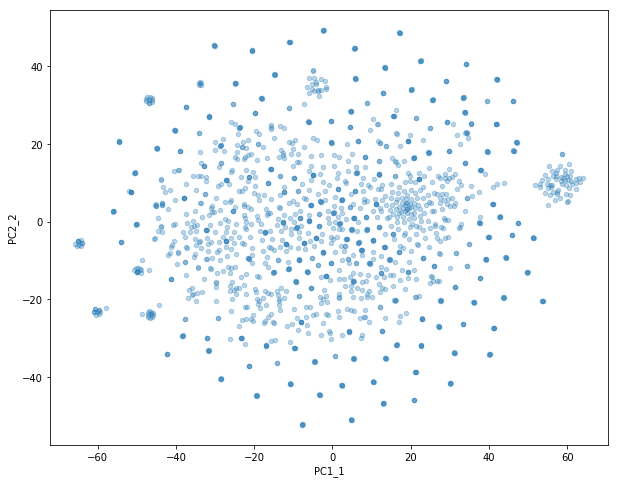

In [137]:
#查看粤菜和川菜的子集分别是什么菜谱
df['PC1_1'] = X_embedded.T[0]
df['PC2_2'] = X_embedded.T[1]
df.plot('PC1_1', 'PC2_2', kind='scatter', alpha=0.3, figsize=(10,8))

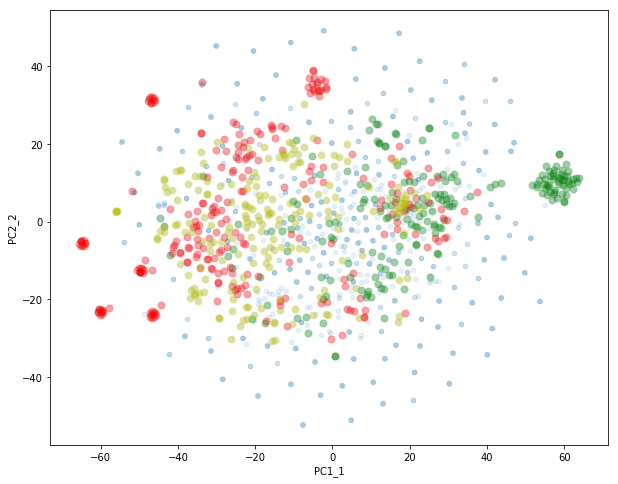

In [150]:
myax = df.plot('PC1_1', 'PC2_2', kind='scatter', alpha=0.1, figsize=(10,8))
df[df['colour']=='Guangdong_cuisine'].plot('PC1_1', 'PC2_2', kind='scatter', color='green', ax=myax, alpha=0.3, s=50)
df[df['colour']=='Sichuan_cuixine'].plot('PC1_1', 'PC2_2', kind='scatter', color='red', ax=myax, alpha=0.3, s=50)
df[df['colour']=='Hunan_cuisine'].plot('PC1_1', 'PC2_2', kind='scatter', color='y', ax=myax, alpha=0.3, s=50)
#df[df['colour']==2].plot('PC1_1', 'PC2_2', kind='scatter', color='b', ax=myax, alpha=0.3, s=50)

In [160]:
df_B=df[
    (df['PC1_1']>-20)& (df['PC1_1'] < 0)
    &
    (df['PC2_2'] > 20) & (df['PC2_2'] < 40)
]#value_counts()
#df_B 泡菜

In [153]:
df_C=df[(df['PC1_1'] >50)]#['colour'].value_counts()
#df_C广式月饼

In [162]:
df_D=df[
    (df['PC1_1'] <-55)&(df['PC1_1'] >-65)
    &
    (df['PC2_2'] <-20)&(df['PC2_2'] >-30)
]#['colour'].value_counts()
#df_D  水煮肉片

In [164]:
df_E=df[
    (df['PC1_1'] <-40)&(df['PC1_1'] >-50)
    &
    (df['PC2_2'] <-20)&(df['PC2_2'] >-30)
]#['colour'].value_counts()
#df_E 宫爆鸡丁 

In [166]:
df_F=df[
    (df['PC1_1'] <-40)&(df['PC1_1'] >-50)
    &
    (df['PC2_2'] <40)&(df['PC2_2'] >20)
]#['colour'].value_counts()
#df_F 川味凉面